# Bayesian synthesis of the neuroimaging literature

The overall goal of this project is to employ Bayesian inference methods in order to estimate topics for mental functions, which are then evaluated by how well they predict brain activity. We will compare topics derived in an unsupervised manner from the neuroimaging literature against those constrained to the match the content of the Research Domain Criteria (RDoC) framework set forth by the National Institute of Mental Health to guide research in biological psychiatry. Latent Dirichlet allocation (LDA) will be applied as the unsupervised topic modeling approach, and labeled LDA will allow us to match the topics to the constructs of the RDoC framework. Topic modeling will be performed on a corpus of 18,155 human neuroimaging articles that reported spatial locations in the brain found to relate with mental functions. The mental functioning topics will be evaluated not only by perplexity, which is the usual measure of word likelihood under the model, but also by how well they predict reported locations in the brain. This will characterize the biological basis for mental functioning topics and offer the first systematic validation of the RDoC framework.

<img src="figures/figure01.png" style="width: 650px;">

## Load the text data

Standard preprocessing was applied to the texts including stop word removal, case folding, and lemmatization. The preprocessed texts were then tokenized with a vocabulary of words previously found to be semantic synonyms with words from the RDoC matrix.

In [1]:
import os
import pandas as pd

In [3]:
rdoc = pd.read_csv("data/rdoc_constructs.csv", index_col=None, header=0)
vocab = sorted(list(set(rdoc["TOKEN"])))
len(vocab)

427

#### Abstracts

In [4]:
atm_df = pd.read_csv("data/atm.csv", index_col=0)
atm_df.head()

,aberrant_behavior_checklist,acoustic_processing,action,action_perception,active_maintenance,acute_threat,adult_attachment_interview,affect_recognition,affective_prosody,affective_state,...,wake_time,wakefulness,waking,wanting,wisconsin_card_sorting_test,withdrawal,word,working_memory_maintenance,working_memory_updating,worry
16806838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22039428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27085513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
24240601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20226769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Full texts

In [5]:
dtm_df = pd.read_csv("data/dtm.csv.gz", compression="gzip", index_col=0, header=0)
dtm_df.head()

,2ndorder_rule_acquisition,2stage_decision_task,3d_object,abductive_reasoning,abductive_reasoning_activity,abductive_reasoning_function,aberrant_behavior,aberrant_behavior_checklist,aberrant_behavior_checklist_community,ability,...,ybocs_total_score,yellow_light_game,young_mania_rating_scale,youth_alcohol_consumption,youth_drinking,youth_life_stress,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
12953303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15858160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17280517,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18372290,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12518293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Latent Dirichlet allocation (LDA)

### Train SKLearn implementation

In [6]:
import pickle
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
splits = {"train": [], "validate": [], "test": []}
for split in splits.keys():
    splits[split] = [int(id.strip()) for id in open("data/pmids_{}.txt".format(split)).readlines()]

In [8]:
n_components = 42
n_iters = [25, 50, 100, 200]
n_texts = [250, 1000, 2000, 3000, len(splits["train"])]

#### Abstracts

In [9]:
# lda = pickle.load(open("lda/lda_fit_12708abstracts_200iter.p", "r"))
# theta = np.multiply(lda.components_.T, 1/lda.components_.sum(axis=1)[:, np.newaxis].T)
# theta = pd.DataFrame(theta, index=vocab, columns=range(1,43))

In [13]:
mod_abs, theta_abs, perp_abs = [], [], []
for n_text in n_texts:
    for i, n_iter in enumerate(n_iters):
        lda = LatentDirichletAllocation(n_components=n_components, learning_method="online", learning_decay=0.7, 
                                        learning_offset=10.0, max_iter=n_iter, batch_size=128, evaluate_every=-1, 
                                        total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, 
                                        max_doc_update_iter=100, random_state=42, verbose=1)
        lda.fit(atm_df.loc[splits["train"]][:n_text])
        mod_abs.append(lda)
        theta = np.multiply(lda.components_.T, 1/lda.components_.sum(axis=1)[:, np.newaxis].T)
        theta = pd.DataFrame(theta, index=vocab, columns=range(1,43))
        theta_abs.append(theta)
        perp = lda.perplexity(atm_df.loc[splits["train"]][:n_text])
        perp_abs.append(perp)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [23]:
for i in range(1,n_components+1):
    print("-"*50 + "\nTOPIC {}".format(i))
    print(theta[i].sort_values(ascending=False)[:5])
    print()

--------------------------------------------------
TOPIC 1
anhedonia         0.306104
attitude          0.269557
somatic           0.146955
antisaccades      0.102357
harm_avoidance    0.069930
Name: 1, dtype: float64
()
--------------------------------------------------
TOPIC 2
agent              0.365475
attachment         0.350986
cry                0.139154
joint_attention    0.067398
laughing           0.021943
Name: 2, dtype: float64
()
--------------------------------------------------
TOPIC 3
arousal        0.448014
stroop_task    0.210341
stroop         0.194823
worry          0.055659
temperament    0.051844
Name: 3, dtype: float64
()
--------------------------------------------------
TOPIC 4
feedback                  0.546958
executive_function        0.190604
expectancy                0.109744
semantics                 0.061538
performance_monitoring    0.039264
Name: 4, dtype: float64
()
--------------------------------------------------
TOPIC 5
sleep                0.3484

In [91]:
pickle.dump(lda, open("lda/lda_fit_12708abstracts_200iter.p", "wb"), protocol=2)

#### Full texts

In [10]:
flda = pickle.load(open("lda/lda_fit_12708fulltexts_200iter.p", "r"))
ftheta = np.multiply(flda.components_.T, 1/flda.components_.sum(axis=1)[:, np.newaxis].T)
ftheta = pd.DataFrame(ftheta, index=vocab, columns=range(1,43))

In [12]:
mod_full, theta_full, perp_full = [], [], []
for n_text in n_texts:
    print("-"*50 + "\n{} TEXTS\n".format(n_text) + "-"*50)
    for i, n_iter in enumerate(n_iters):
        flda = LatentDirichletAllocation(n_components=n_components, learning_method="online", learning_decay=0.7, 
                                        learning_offset=10.0, max_iter=n_iter, batch_size=128, evaluate_every=-1, 
                                        total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, 
                                        max_doc_update_iter=100, random_state=42, verbose=1)
        flda.fit(dtm_df.loc[splits["train"], vocab][:n_text])
        mod_full.append(flda)
        ftheta = np.multiply(flda.components_.T, 1/flda.components_.sum(axis=1)[:, np.newaxis].T)
        ftheta = pd.DataFrame(ftheta, index=vocab, columns=range(1,43))
        theta_full.append(ftheta)
        perp = flda.perplexity(dtm_df.loc[splits["train"], vocab][:n_text])
        perp_full.append(perp)
perp_full

--------------------------------------------------
12708 TEXTS
--------------------------------------------------
iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 

[32.08585892624901]

In [27]:
for i in range(1,n_components+1):
    print("-"*50 + "\nTOPIC {}".format(i))
    print(ftheta[i].sort_values(ascending=False)[:5])
    print()

--------------------------------------------------
TOPIC 1
decision           0.466155
suppression        0.146505
decision_making    0.117035
vestibular         0.072160
uncertainty        0.026999
Name: 1, dtype: float64
()
--------------------------------------------------
TOPIC 2
meaning                0.288585
semantic_processing    0.115101
representation         0.097042
semantics              0.066751
word                   0.056455
Name: 2, dtype: float64
()
--------------------------------------------------
TOPIC 3
stress             0.527956
gaze               0.279626
rumination         0.066375
eye_gaze           0.028620
joint_attention    0.022472
Name: 3, dtype: float64
()
--------------------------------------------------
TOPIC 4
feedback                  0.539081
prediction_error          0.102272
expectancy                0.101232
reinforcement_learning    0.037591
selfesteem                0.034591
Name: 4, dtype: float64
()
-----------------------------------------

In [14]:
pickle.dump(flda, open("lda/lda_fit_12708fulltexts_200iter.p", "wb"), protocol=2)

In [ ]:
df = theta_full[-1]
df.to_csv("lda/lda_python_12708fulltexts_200iter.csv", header=None)

### Plot perplexity over iterations

In [11]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import cm
avenir = "visuals/Avenir.ttf"

In [19]:
df_n_texts, df_n_iter = [], []
for n_text in n_texts:
    for i, n_iter in enumerate(n_iters):
        df_n_texts.append(n_text)
        df_n_iter.append(n_iter)

In [165]:
perp_df = pd.DataFrame({"N_TEXT": df_n_texts*2, "N_ITER": df_n_iter*2, 
                        "TEXT_TYPE": ["Abstract"]*20 + ["Full Text"]*20,
                        "PERPLEXITY": perp_abs + perp_full})
perp_df.to_csv("lda/lda_python_perplexity.csv", index=None)
perp_df.head()

,N_ITER,N_TEXT,PERPLEXITY,TEXT_TYPE
0,25,250,86.266558,Abstract
1,50,250,62.915069,Abstract
2,100,250,61.054144,Abstract
3,200,250,59.686052,Abstract
4,25,1000,55.250043,Abstract


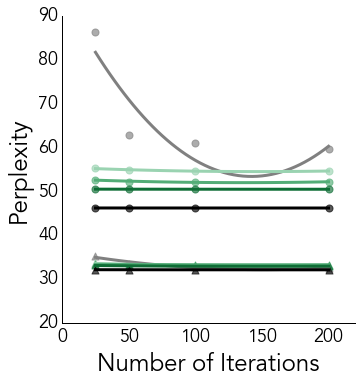

In [168]:
# Initialize the figure
fig = plt.figure(figsize=[5.25, 5.5])

colors = ["gray", "#9ad3b1", "#53ad77", "#0e6d35", "black"]
for i, n_text in enumerate(n_texts):
    
    # Plot full texts as triangles
    plt.scatter(perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "N_ITER"], 
                perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"],
                color=colors[i], alpha=0.65, s=50, marker="^")

    # Plot abstracts as circles
    plt.scatter(perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "N_ITER"], 
                perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"],
                color=colors[i], alpha=0.65, s=50)


    # Fit curve for full texts
    z = np.polyfit(perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "N_ITER"], 
                   perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"], 2)
    f = np.poly1d(z)
    x_new = np.linspace(df_n_iter[0], df_n_iter[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, color=colors[i], linewidth=3)

    # Fit curve for abstracts
    z = np.polyfit(perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "N_ITER"], 
                   perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"], 2)
    f = np.poly1d(z)
    x_new = np.linspace(df_n_iter[0], df_n_iter[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, color=colors[i], linewidth=3)

# Style
font_labels = font_manager.FontProperties(fname=avenir, size=24)
font_ticks = font_manager.FontProperties(fname=avenir, size=18)
plt.xlabel("Number of Iterations", fontproperties=font_labels)
plt.ylabel("Perplexity", fontproperties=font_labels)
plt.xticks(fontproperties=font_ticks)
plt.yticks(fontproperties=font_ticks)
plt.xlim([0,220])
# plt.ylim([0,100])
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False) 

# Export
plt.savefig("visuals/lda_constructs_perplexity_python.png", bbox_inches="tight", dpi=250)
plt.show()

### Distributions of words in each topic

In [16]:
from wordcloud import WordCloud

In [17]:
from matplotlib.colors import LinearSegmentedColormap
colormap = LinearSegmentedColormap.from_list("colormap", [(0, 0, 0), (0, 0, 0), (0, 0, 0)], N=100)

In [18]:
df = pd.read_csv("lda/lda_python_12708fulltexts_200iter.csv", index_col=0, header=None)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,,,,,,,,,,,,,,,,,,,,,
aberrant_behavior_checklist,5.076108e-07,6.160101e-07,9.909293e-07,6.061023e-07,3.466501e-07,4.905632e-07,3.811909e-07,5.605450e-07,3.452273e-07,0.000001,...,3.629472e-07,1.714260e-07,7.877552e-07,2.232570e-07,4.738589e-07,0.000003,2.725070e-07,5.674935e-07,0.000001,6.786830e-07
acoustic_processing,5.076108e-07,6.160100e-07,9.909292e-07,6.061023e-07,3.466501e-07,4.905632e-07,3.811908e-07,5.605449e-07,3.452273e-07,0.000001,...,3.629472e-07,1.714260e-07,7.877552e-07,2.232570e-07,4.738589e-07,0.000003,2.725070e-07,5.674935e-07,0.000001,6.786830e-07
action,5.730148e-03,4.216588e-03,9.909292e-07,1.205773e-02,9.650548e-04,7.623456e-03,3.811908e-07,7.239959e-07,3.452273e-07,0.000001,...,2.596021e-03,1.929120e-03,7.877552e-07,2.232570e-07,5.715317e-03,0.000003,8.506013e-04,5.674935e-07,0.002130,3.743518e-03
action_perception,5.076108e-07,6.160100e-07,9.909292e-07,6.061023e-07,3.466501e-07,4.905632e-07,3.811908e-07,5.605449e-07,3.452273e-07,0.000001,...,3.629472e-07,1.714260e-07,7.877552e-07,2.232570e-07,4.738589e-07,0.000003,2.725070e-07,5.674935e-07,0.000001,6.786830e-07
active_maintenance,5.076108e-07,6.160100e-07,9.909292e-07,6.061023e-07,3.466501e-07,1.133080e-03,3.811908e-07,5.605449e-07,3.452273e-07,0.000001,...,3.629472e-07,5.902907e-05,7.877552e-07,2.232570e-07,4.738589e-07,0.000003,2.725070e-07,5.674935e-07,0.000001,5.929765e-03


In [22]:
raw_colors = [[200, 128, 107], [119, 181, 138], [133, 139, 155], [202, 126, 107], [118, 181, 138], [119, 181, 138], [140, 150, 146], [137, 169, 131], [119, 181, 138], [119, 181, 138], [119, 180, 137], [158, 144, 137], [119, 181, 138], [124, 125, 159], [198, 188, 111], [204, 124, 106], [119, 181, 138], [119, 181, 138], [124, 138, 158], [124, 116, 162], [119, 139, 162], [151, 160, 125], [184, 128, 119], [119, 180, 138], [119, 181, 138], [160, 151, 123], [119, 181, 138], [119, 177, 139], [120, 168, 142], [119, 181, 138], [119, 181, 138], [153, 148, 141], [119, 181, 138], [119, 181, 138], [119, 170, 142], [125, 116, 163], [124, 116, 162], [143, 183, 129], [123, 123, 162], [148, 139, 146], [158, 147, 128], [175, 144, 116]]

In [49]:
colors = []
for color in raw_colors:
    colors.append(tuple([float(c)/255.0 for c in color]))

In [52]:
colormaps = [LinearSegmentedColormap.from_list("colormap", [colors[i], colors[i], colors[i]], N=100) for i in range(len(colors))]

TOPIC 1
TOPIC 2
TOPIC 3
TOPIC 4
TOPIC 5
TOPIC 6
TOPIC 7
TOPIC 8
TOPIC 9
TOPIC 10
TOPIC 11
TOPIC 12
TOPIC 13
TOPIC 14
TOPIC 15
TOPIC 16
TOPIC 17
TOPIC 18
TOPIC 19
TOPIC 20
TOPIC 21
TOPIC 22
TOPIC 23
TOPIC 24
TOPIC 25
TOPIC 26
TOPIC 27
TOPIC 28
TOPIC 29
TOPIC 30
TOPIC 31
TOPIC 32
TOPIC 33
TOPIC 34
TOPIC 35
TOPIC 36
TOPIC 37
TOPIC 38
TOPIC 39
TOPIC 40
TOPIC 41
TOPIC 42


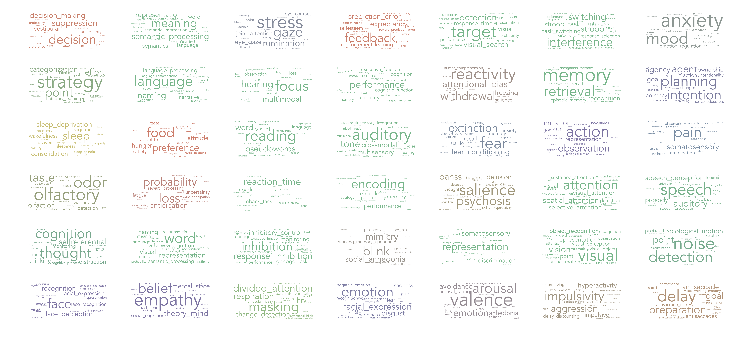

In [54]:
max_words = 20
fig, axs = plt.subplots(6, 7, figsize=(10, 4.5))
axs = axs.ravel()
for i in range(len(df.columns)):
    top_words = df[i+1].sort_values(ascending=False)[:max_words]
    top_words = top_words[top_words > 0]
    vals = [int(val*10000000) for val in top_words.values]
    words = {word: vals[j] for j, word in enumerate(top_words.index)}
    wordcloud = WordCloud(width=950, height=450,
                          prefer_horizontal=1,
                          max_words=max_words,
                          background_color="white", 
                          font_path=avenir,
                          colormap=colormaps[i]).generate_from_frequencies(words)
    axs[i].imshow(wordcloud)
    axs[i].axis("off")
plt.tight_layout(pad=0)
plt.savefig("visuals/lda_constructs_wordsByTopic_python_12708fulltexts_200iter.png".format(i), bbox_inches="tight", dpi=250)
plt.show()

# Labeled LDA

## Plot perplexity over number of iterations

In [13]:
perp_df = pd.read_csv("llda/llda_perplexity.csv")
perp_df = perp_df.loc[(perp_df["ALPHA"] == 0.1) & (perp_df["BETA"] == 0.1)]
perp_df.head()

,X,INDEX,N_TEXT,ITERATION,ALPHA,BETA,PERPLEXITY
0,llda_fulltexts,0.0,250.0,25.0,0.1,0.1,99.970239
25,llda_fulltexts,25.0,250.0,50.0,0.1,0.1,99.676376
50,llda_fulltexts,50.0,250.0,100.0,0.1,0.1,98.451601
75,llda_fulltexts,75.0,250.0,200.0,0.1,0.1,98.451601
100,llda_fulltexts,100.0,1000.0,25.0,0.1,0.1,99.326993


In [17]:
perp_df["TEXT_TYPE"] = [val.replace("llda_", "").replace("fulltexts", "Full Text").replace("abstracts", "Abstract") for val in perp_df["X"]]
perp_df.head()

,X,INDEX,N_TEXT,ITERATION,ALPHA,BETA,PERPLEXITY,TEXT_TYPE
0,llda_fulltexts,0.0,250.0,25.0,0.1,0.1,99.970239,Full Text
25,llda_fulltexts,25.0,250.0,50.0,0.1,0.1,99.676376,Full Text
50,llda_fulltexts,50.0,250.0,100.0,0.1,0.1,98.451601,Full Text
75,llda_fulltexts,75.0,250.0,200.0,0.1,0.1,98.451601,Full Text
100,llda_fulltexts,100.0,1000.0,25.0,0.1,0.1,99.326993,Full Text


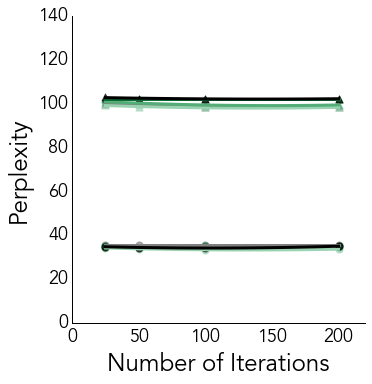

In [21]:
# Initialize the figure
fig = plt.figure(figsize=[5.25, 5.5])

colors = ["gray", "#9ad3b1", "#53ad77", "#0e6d35", "black"]
for i, n_text in enumerate(n_texts):
    
    # Plot full texts as triangles
    plt.scatter(perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "ITERATION"], 
                perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"],
                color=colors[i], alpha=0.65, s=50, marker="^")

    # Plot abstracts as circles
    plt.scatter(perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "ITERATION"], 
                perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"],
                color=colors[i], alpha=0.65, s=50)


    # Fit curve for full texts
    z = np.polyfit(perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "ITERATION"], 
                   perp_df.loc[(perp_df["TEXT_TYPE"] == "Full Text") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"], 2)
    f = np.poly1d(z)
    x_new = np.linspace(df_n_iter[0], df_n_iter[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, color=colors[i], linewidth=3)

    # Fit curve for abstracts
    z = np.polyfit(perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "ITERATION"], 
                   perp_df.loc[(perp_df["TEXT_TYPE"] == "Abstract") & (perp_df["N_TEXT"] == n_text), "PERPLEXITY"], 2)
    f = np.poly1d(z)
    x_new = np.linspace(df_n_iter[0], df_n_iter[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, color=colors[i], linewidth=3)

# Style
font_labels = font_manager.FontProperties(fname=avenir, size=24)
font_ticks = font_manager.FontProperties(fname=avenir, size=18)
plt.xlabel("Number of Iterations", fontproperties=font_labels)
plt.ylabel("Perplexity", fontproperties=font_labels)
plt.xticks(fontproperties=font_ticks)
plt.yticks(fontproperties=font_ticks)
plt.xlim([0,220])
plt.ylim([0,140])
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False) 

# Export
plt.savefig("visuals/llda_constructs_perplexity_python.png", bbox_inches="tight", dpi=250)
plt.show()

# Logistic regression

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

## Load optimal models

In [22]:
grid_df = pd.read_csv("infer/rocauc.csv", index_col=None, header=0)
grid_df.head()

,X,INDEX,C,INTERCEPT,MAX_ITER,PENALTY,TOLERANCE,ROC_AUC
0,lda_fulltexts,0.0,0.001,True,200.0,l1,0.00001,0.5
1,lda_fulltexts,1.0,0.001,True,200.0,l1,0.00010,0.5
2,lda_fulltexts,2.0,0.001,True,200.0,l1,0.00100,0.5
3,lda_fulltexts,3.0,0.001,True,200.0,l1,0.01000,0.5
4,lda_fulltexts,4.0,0.001,True,200.0,l1,0.10000,0.5


In [43]:
clf_names = ["lda_fulltexts", "lda_abstracts", "llda_fulltexts", "llda_abstracts", "rdoc", "bow_vocab", "bow_all"]
clf_idx = []
for name in clf_names:
    df = grid_df.loc[grid_df["X"] == name].sort_values("ROC_AUC", ascending=False)
    clf_idx.append(df["INDEX"].values[0])
    print("{:15s}:  ROC-AUC = {:2.4f}  IDX = {:3.0f}".format(name, df["ROC_AUC"].values[0], df["INDEX"].values[0]))

lda_fulltexts  :  ROC-AUC = 0.6289  IDX =  73
lda_abstracts  :  ROC-AUC = 0.5919  IDX =  62
llda_fulltexts :  ROC-AUC = 0.6053  IDX = 100
llda_abstracts :  ROC-AUC = 0.6013  IDX =  66
rdoc           :  ROC-AUC = 0.6161  IDX =  40
bow_vocab      :  ROC-AUC = 0.6374  IDX =  20
bow_all        :  ROC-AUC = 0.6524  IDX =  20


## Plot test set ROC curves

In [75]:
prop_sm = font_manager.FontProperties(fname=avenir, size=12)
prop_md = font_manager.FontProperties(fname=avenir, size=18)
prop_lg = font_manager.FontProperties(fname=avenir, size=20)
prop_xlg = font_manager.FontProperties(fname=avenir, size=24)
prop_title = font_manager.FontProperties(fname=avenir, size=26)

In [76]:
def plot_roc(clf, X, title, color="gray"):
    fig = plt.figure(figsize=[4, 4])
    y_true = Y.loc[splits["test"]]
    probas_pred = clf.predict_proba(X.loc[splits["test"]])
    plt.plot([2,2], [2,2], label="Forward Inference", c="gray", linewidth=2)
    for j in range(Y.shape[1]):
        structure = Y.columns[j]
        fpr, tpr, thresholds = roc_curve(y_true.values[:,j], probas_pred[:,j], pos_label=1)
        plt.plot(fpr, tpr, alpha=0.2, c=color, linewidth=1.5)
    score = roc_auc_score(y_true.values, probas_pred, average="macro")
    print("ROC-AUC: {}".format(score))
    lim = [-0.05, 1.05]
    plt.xlim(lim)
    plt.ylim(lim)
    ax = plt.subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    plt.xticks(fontproperties=prop_md)
    plt.yticks(fontproperties=prop_md)
    plt.xlabel("1 - Specificity", fontproperties=prop_xlg)
    plt.ylabel("Sensitivity", fontproperties=prop_xlg)
    plt.plot([-1,2], [-1,2], linestyle="dashed", c="k", alpha=0.85, linewidth=1.5)
    plt.tight_layout()
    plt.savefig("visuals/roc_python_{}.png".format(title), bbox_inches="tight", dpi=250)
    plt.show()

In [44]:
Y = pd.read_csv("data/coordinates.csv", index_col=0, header=0)
Y.head()

,left_accumbens,left_amygdala,left_angular_gyrus,left_brainstem,left_caudate,left_central_opercular_cortex,left_cerebellum,left_cingulate_gyrus_anterior_division,left_cingulate_gyrus_posterior_division,left_cuneal_cortex,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1410086,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1448149,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1486459,0,0,1,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
1486460,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0


In [71]:
Xs = ["lda/lda_theta_12708fulltexts_200iter.csv", "lda/lda_theta_12708abstracts_200iter.csv",
      "llda/llda_fulltexts_topicDistForDoc_475_18155docs.csv", "llda/llda_abstracts_topicDistForDoc_475_18155docs.csv",
      "data/rdoc_scores.csv", "data/bow_vocab.csv", "data/bow_all.csv"]

In [52]:
colors = ["#346e49", "#9ad3b1", "#346e49", "#9ad3b1", "#346e49", "#346e49", "#346e49"]

--------------------------------------------------
LDA_FULLTEXTS
--------------------------------------------------
ROC-AUC: 0.631160484368


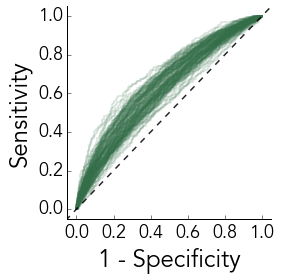

--------------------------------------------------
LDA_ABSTRACTS
--------------------------------------------------
ROC-AUC: 0.59532498376


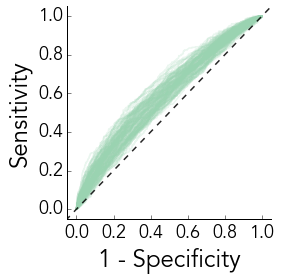

--------------------------------------------------
LLDA_FULLTEXTS
--------------------------------------------------
ROC-AUC: 0.608641781708


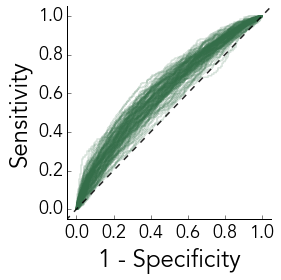

--------------------------------------------------
LLDA_ABSTRACTS
--------------------------------------------------
ROC-AUC: 0.59753439929


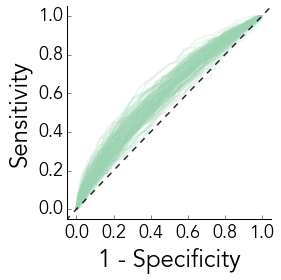

--------------------------------------------------
RDOC
--------------------------------------------------
ROC-AUC: 0.617889047559


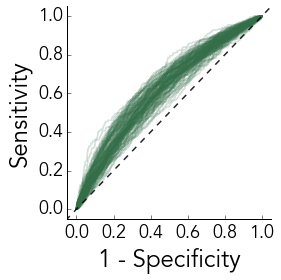

--------------------------------------------------
BOW_VOCAB
--------------------------------------------------
ROC-AUC: 0.632437782454


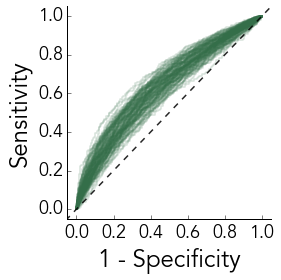

--------------------------------------------------
BOW_ALL
--------------------------------------------------
ROC-AUC: 0.643572630315


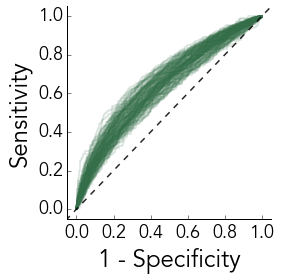

In [77]:
for i, name in enumerate(clf_names):
    print("-"*50 + "\n" + name.upper() + "\n" + "-"*50)
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    plot_roc(clf, X, name, color=colors[i])

## Compare models by ROC-AUC

### Observed scores

In [104]:
scores_rocauc = []
for i, name in enumerate(clf_names):
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    y_true = Y.loc[splits["test"]]
    probas_pred = clf.predict_proba(X.loc[splits["test"]])
    scores_rocauc.append(roc_auc_score(y_true.values, probas_pred, average="macro"))

### Bootstrap distributions

In [166]:
n_iter = 1000
boot = [np.random.choice(splits["test"], len(splits["test"]), replace=True) for n in range(n_iter)]

In [167]:
def boot_rocauc(clf, X):
    scores = []
    for n in range(len(boot)):
        y_true = Y.loc[boot[n]]
        probas_pred = clf.predict_proba(X.loc[boot[n]])
        scores.append(roc_auc_score(y_true.values, probas_pred, average="macro"))
    return scores

In [168]:
boots_rocauc = []
for i, name in enumerate(clf_names):
    print("Computing bootstrap for {}".format(name))
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    boots_rocauc.append(boot_rocauc(clf, X))

Computing bootstrap for lda_fulltexts
Computing bootstrap for lda_abstracts
Computing bootstrap for llda_fulltexts
Computing bootstrap for llda_abstracts
Computing bootstrap for rdoc
Computing bootstrap for bow_vocab
Computing bootstrap for bow_all


### Null distributions

In [169]:
n_iter = 1000
null = [np.random.choice(splits["test"], len(splits["test"]), replace=False) for n in range(n_iter)]

In [170]:
def null_rocauc(clf, X):
    scores = []
    for n in range(len(null)):
        y_true = Y.loc[null[n]]
        probas_pred = clf.predict_proba(X.loc[splits["test"]])
        scores.append(roc_auc_score(y_true.values, probas_pred, average="macro"))
    return scores

In [ ]:
nulls_rocauc = []
for i, name in enumerate(clf_names):
    print("Computing null for {}".format(name))
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    nulls_rocauc.append(null_rocauc(clf, X))

Computing null for lda_fulltexts
Computing null for lda_abstracts
Computing null for llda_fulltexts
Computing null for llda_abstracts
Computing null for rdoc
Computing null for bow_vocab
Computing null for bow_all


### Violin plots

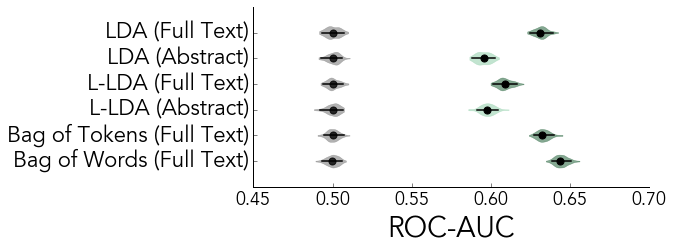

In [148]:
fig = plt.figure(figsize=[5.5, 2.5])
ax = fig.add_axes([0,0,1,1])
pos = [6,5,4,3,3,2,1]
prop_lg = font_manager.FontProperties(fname=avenir, size=18)
prop_xlg = font_manager.FontProperties(fname=avenir, size=28)
font_ticks = font_manager.FontProperties(fname=avenir, size=22)
for i, name in enumerate(clf_names):
    if name != "rdoc":
        v = ax.violinplot(boots_rocauc[i], positions=[pos[i]], vert=False, widths=0.5, 
                          showmeans=False, showextrema=False, showmedians=False)
        for pc in v["bodies"]:
                pc.set_facecolor(colors[i])
                pc.set_edgecolor(colors[i])
                pc.set_linewidth(0.5)
                pc.set_alpha(0.6)
        plt.scatter([scores_rocauc[i]], [pos[i]], c="k", alpha=1, s=50)
        data = sorted(boots_rocauc[i])
        plt.plot([data[int(n_iter*0.05)], data[int(n_iter*0.95)]], [pos[i], pos[i]],
                 c="k", lw=1.5)
        
        v = ax.violinplot(nulls_rocauc[i], positions=[pos[i]], vert=False, widths=0.5, 
                          showmeans=False, showextrema=False, showmedians=False)
        for pc in v["bodies"]:
                pc.set_facecolor("gray")
                pc.set_edgecolor("gray")
                pc.set_linewidth(0.5)
                pc.set_alpha(0.6)
        plt.scatter([np.mean(nulls_rocauc[i])], [pos[i]], c="k", alpha=0.8, s=50)
        data = sorted(nulls_rocauc[i])
        plt.plot([data[int(n_iter*0.05)], data[int(n_iter*0.95)]], [pos[i], pos[i]],
                 c="k", lw=1.5)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
plt.xticks(fontproperties=prop_lg)
plt.yticks(fontproperties=prop_xlg)
plt.xlabel("ROC-AUC", fontproperties=prop_xlg)
plt.yticks(range(1,7), fontproperties=font_ticks)
titles = reversed(["LDA (Full Text)", "LDA (Abstract)", "L-LDA (Full Text)", "L-LDA (Abstract)", "Bag of Tokens (Full Text)", "Bag of Words (Full Text)"])
ax.set_yticklabels(titles)
plt.savefig("visuals/rocauc_python.png", bbox_inches="tight", dpi=250)
plt.show()

## Compare models by Bayesian information criterion (BIC)

### Observed scores

In [137]:
scores_bic = []
n_obs = len(splits["test"])
for i, name in enumerate(clf_names):
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    k = X.shape[1]
    y_true = np.array(Y.loc[splits["test"]])
    probas_pred = np.array(clf.predict_proba(X.loc[splits["test"]]))
    resid = y_true - probas_pred
    sse = np.sum(resid**2, axis=0)
    BIC = np.mean((n_obs*np.log(sse/n_obs)) + (k*np.log(n_obs)))
    scores_bic.append(BIC)

### Bootstrap distributions

In [139]:
def boot_bic(clf, X):
    scores = []
    n_obs = len(splits["test"])
    k = X.shape[1]
    for n in range(len(boot)):
        y_true = np.array(Y.loc[boot[n]])
        probas_pred = np.array(clf.predict_proba(X.loc[boot[n]]))
        resid = y_true - probas_pred
        sse = np.sum(resid**2, axis=0)
        BIC = np.mean((n_obs*np.log(sse/n_obs)) + (k*np.log(n_obs)))
        scores.append(BIC)
    return scores

In [140]:
boots_bic = []
for i, name in enumerate(clf_names):
    print("Computing bootstrap for {}".format(name))
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    boots_bic.append(boot_bic(clf, X))

Computing bootstrap for lda_fulltexts
Computing bootstrap for lda_abstracts
Computing bootstrap for llda_fulltexts
Computing bootstrap for llda_abstracts
Computing bootstrap for rdoc
Computing bootstrap for bow_vocab
Computing bootstrap for bow_all


### Null distributions

In [149]:
def null_bic(clf, X):
    scores = []
    n_obs = len(splits["test"])
    k = X.shape[1]
    for n in range(len(null)):
        y_true = np.array(Y.loc[null[n]])
        probas_pred = np.array(clf.predict_proba(X.loc[splits["test"]]))
        resid = y_true - probas_pred
        sse = np.sum(resid**2, axis=0)
        BIC = np.mean((n_obs*np.log(sse/n_obs)) + (k*np.log(n_obs)))
        scores.append(BIC)
    return scores

In [150]:
nulls_bic = []
for i, name in enumerate(clf_names):
    print("Computing null for {}".format(name))
    clf = pickle.load(open("infer/{}/infer_{}.p".format(name, int(clf_idx[i]), "r")))
    X = pd.read_csv(Xs[i], index_col=0, header=0)
    nulls_bic.append(null_bic(clf, X))

Computing null for lda_fulltexts
Computing null for lda_abstracts
Computing null for llda_fulltexts
Computing null for llda_abstracts
Computing null for rdoc
Computing null for bow_vocab
Computing null for bow_all


### Violin plots

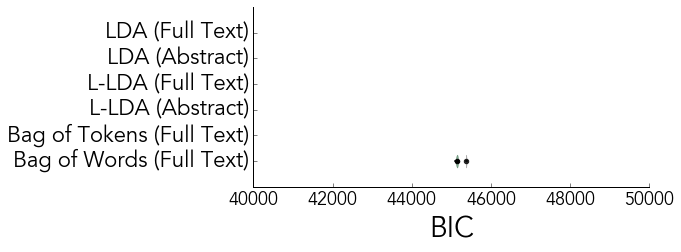

In [165]:
fig = plt.figure(figsize=[5.5, 2.5])
ax = fig.add_axes([0,0,1,1])
pos = [6,5,4,3,3,2,1]
prop_lg = font_manager.FontProperties(fname=avenir, size=18)
prop_xlg = font_manager.FontProperties(fname=avenir, size=28)
font_ticks = font_manager.FontProperties(fname=avenir, size=22)
for i, name in enumerate(clf_names):
    if name != "rdoc":
        v = ax.violinplot(boots_bic[i], positions=[pos[i]], vert=False, widths=0.5, 
                          showmeans=False, showextrema=False, showmedians=False)
        for pc in v["bodies"]:
                pc.set_facecolor(colors[i])
                pc.set_edgecolor(colors[i])
                pc.set_linewidth(0.5)
                pc.set_alpha(0.6)
        plt.scatter([scores_bic[i]], [pos[i]], c="k", alpha=1, s=20)
        data = sorted(boots_bic[i])
        plt.plot([data[int(n_iter*0.05)], data[int(n_iter*0.95)]], [pos[i], pos[i]],
                 c="k", lw=1.5)
        
        v = ax.violinplot(nulls_bic[i], positions=[pos[i]], vert=False, widths=0.5, 
                          showmeans=False, showextrema=False, showmedians=False)
        for pc in v["bodies"]:
                pc.set_facecolor("gray")
                pc.set_edgecolor("gray")
                pc.set_linewidth(0.5)
                pc.set_alpha(0.6)
        plt.scatter([np.mean(nulls_bic[i])], [pos[i]], c="k", alpha=0.8, s=20)
        data = sorted(nulls_bic[i])
        plt.plot([data[int(n_iter*0.05)], data[int(n_iter*0.95)]], [pos[i], pos[i]],
                 c="k", lw=1.5)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
plt.xlim([40000,50000])
plt.xticks(fontproperties=prop_md)
plt.yticks(fontproperties=prop_xlg)
plt.xlabel("BIC", fontproperties=prop_xlg)
plt.yticks(range(1,7), fontproperties=font_ticks)
titles = reversed(["LDA (Full Text)", "LDA (Abstract)", "L-LDA (Full Text)", "L-LDA (Abstract)", "Bag of Tokens (Full Text)", "Bag of Words (Full Text)"])
ax.set_yticklabels(titles)
plt.savefig("visuals/bic_python.png", bbox_inches="tight", dpi=250)
plt.show()